In [1]:
# Import modules
import csv
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss

## Prepare dataset

In [2]:
# Read .csv file by DataFrame with delimiter is ','

train_data = pd.read_csv('train.csv', delimiter=',')
test_data = pd.read_csv('test.csv', delimiter=',')

In [3]:
# Check null data

train_data.isnull().sum()

id           0
species      0
margin1      0
margin2      0
margin3      0
            ..
texture60    0
texture61    0
texture62    0
texture63    0
texture64    0
Length: 194, dtype: int64

In [4]:
# Get 'species' label
train_label = train_data['species']
classes = np.unique(train_label)

# Remove 'id' col and 'species' col of train_data
train_data = train_data.drop(columns=['id', 'species'], axis=1)

# convert to numpy
train_data = np.array(train_data, dtype='float64')
train_label = np.array(train_label)

In [5]:
# Store 'id' of test_data to write to submission.csv
test_ids = test_data['id']

# Remove 'id' col of test_data
test_data = test_data.drop(columns=['id'], axis=1)
test_data = np.array(test_data, dtype='float64')

## Define functions

In [6]:
s_acc = s_loss = 0
def scorer(clf, X_test, y_test):
    '''
    Cal sum of accuracy and loss
    '''
    global s_acc, s_loss
    y_pred = clf.predict(X_test)
    s_acc += accuracy_score(y_test, y_pred)

    y_pred = clf.predict_proba(X_test)
    s_loss += log_loss(y_test, y_pred)
    return s_acc

def score_dataset(clf_name, clf, X, y, cv=5):
    '''
    Return mean accuracy and loss via k-fold cross-validation
    '''
    global s_acc, s_loss
    s_acc = s_loss = 0
    scores = cross_val_score(clf, X, y, cv=cv, scoring=scorer)
    mean_acc = s_acc/cv
    mean_loss = s_loss/cv
    print("%12s %2d-folds = %.3f with loss = %.3f" % (clf_name, cv, mean_acc, mean_loss))
    return mean_acc, mean_loss

## Sklearn Classifier

In [7]:
import pandas as pd
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# try with the classifiers of sklearn
clfs = {
    'kNN': KNeighborsClassifier(n_neighbors=2),
    'GaussianNB': GaussianNB(),
    'DecisionTree': tree.DecisionTreeClassifier(criterion="gini"),
    'Bagging': BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(), n_estimators=20),
    'AdamBoost': AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=2), n_estimators=20),
    'RandomForest': RandomForestClassifier(n_estimators=50),
    'SVM_Linear': svm.SVC(kernel='linear', C=1000, probability=True),
    'SVM_Poly': svm.SVC(kernel='poly', C=1000, probability=True),
    'SVM_RBF': svm.SVC(kernel='rbf', C=1000, gamma=0.01, probability=True),
    'SVM_Sigmoid': svm.SVC(kernel='sigmoid', C=1000, gamma=0.0001, probability=True),
    'LDA': LinearDiscriminantAnalysis(),
}

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in clfs.items():
    # validate with k-fold cross-validation (k=10)
    mean_acc, mean_loss = score_dataset(clf[0], clf[1], train_data, train_label, cv=10)
    log_entry = pd.DataFrame([[clf[0], mean_acc*100, mean_loss]], columns=log_cols)
    log = log.append(log_entry)

         kNN 10-folds = 0.885 with loss = 2.015
  GaussianNB 10-folds = 0.611 with loss = 13.405
DecisionTree 10-folds = 0.693 with loss = 10.606
     Bagging 10-folds = 0.927 with loss = 0.898
   AdamBoost 10-folds = 0.064 with loss = 4.252
RandomForest 10-folds = 0.972 with loss = 0.723
  SVM_Linear 10-folds = 0.958 with loss = 2.192
    SVM_Poly 10-folds = 0.940 with loss = 2.314
     SVM_RBF 10-folds = 0.935 with loss = 2.204
 SVM_Sigmoid 10-folds = 0.801 with loss = 4.646
         LDA 10-folds = 0.978 with loss = 0.350


In [8]:
# Save log
log.to_csv('log.csv', index=False)
log

,Classifier,Accuracy,Log Loss
0,kNN,88.484848,2.015441
0,GaussianNB,61.111111,13.404555
0,DecisionTree,69.292929,10.605846
0,Bagging,92.727273,0.897706
0,AdamBoost,6.363636,4.251605
0,RandomForest,97.171717,0.723276
0,SVM_Linear,95.757576,2.191613
0,SVM_Poly,94.040404,2.314229
0,SVM_RBF,93.535354,2.203910
0,SVM_Sigmoid,80.101010,4.645516


Text(0.5, 1.0, 'Classifier Log Loss')

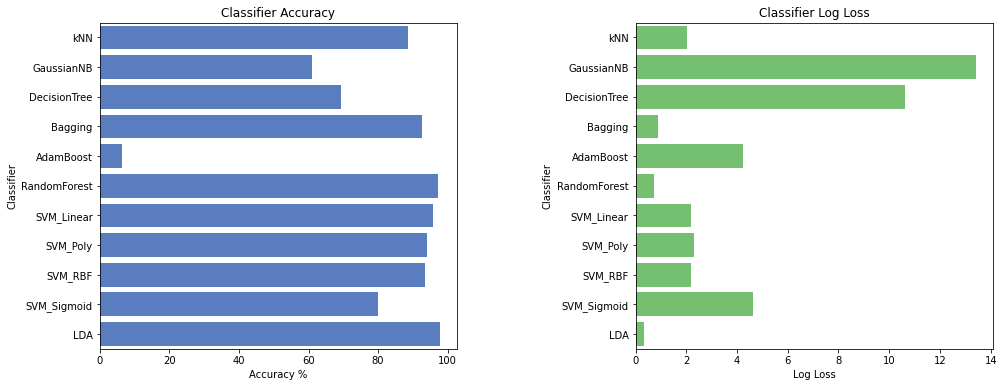

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 6)
plt.subplots_adjust(wspace=0.5)

# Plot Accuracy Figure
plt.subplot(1, 2, 1)
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')

# Plot Log Loss Figure
plt.subplot(1, 2, 2)
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')


## Submission

In [10]:
# Predict Test Set
favorite_clf = RandomForestClassifier(n_estimators=50)
favorite_clf.fit(train_data, train_label)

# Predict with probability
test_predictions = favorite_clf.predict_proba(test_data)

# Format DataFrame
submission = pd.DataFrame(test_predictions, columns=classes)
submission.insert(0, 'id', test_ids)
submission.reset_index()

# Export Submission
submission.to_csv('submission.csv', index = False)
submission.tail()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
589,1576,0.0,0.64,0.0,0.00,0.08,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00
590,1577,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.06,0.04,...,0.00,0.00,0.0,0.00,0.02,0.02,0.0,0.00,0.00,0.00
591,1579,0.0,0.02,0.0,0.00,0.04,0.04,0.00,0.00,0.00,...,0.00,0.00,0.0,0.02,0.00,0.00,0.0,0.00,0.02,0.02
592,1580,0.0,0.00,0.0,0.04,0.00,0.00,0.02,0.00,0.00,...,0.04,0.06,0.0,0.00,0.00,0.02,0.0,0.02,0.00,0.00
593,1583,0.0,0.02,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00
